In [49]:
import pandas as pd
import matplotlib as plt
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, explained_variance_score
from keras.callbacks import EarlyStopping
import math
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 다변량
def split_mult_data(data, timestep, lag):
    x, y = [], []
    for i in range(len(data)):
        end_ix = i + timestep
        out_end_ix = end_ix + lag
        if out_end_ix > len(data):
            break;
        seq_x, seq_y = data[i:end_ix, 1:], data[end_ix:out_end_ix, 0]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

# 단일
def split_data(data, timestep):
    x, y = [], []
    for i in range(len(data)):
        end_ix = i + timestep
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

# 데이터 분할 함수 : 6.2.2
def split(data_x, data_y):
    train_size = int(len(data_x)*0.6)
    val_size = int(len(data_x)*0.8)
    
    data_train_x = data_x[:train_size]
    data_val_x = data_x[train_size:val_size]
    data_test_x = data_x[val_size:]
    
    data_train_y = data_y[:train_size]
    data_val_y = data_y[train_size:val_size]
    data_test_y = data_y[val_size:] 
    
    return data_train_x, data_val_x, data_test_x, data_train_y, data_val_y, data_test_y

def normalization(data_train, data_test):
    scaler = MinMaxScaler() #StandardScaler
    scaler.fit(data_train)
    n_data_train = scaler.transform(data_train)
#     n_data_val = scaler.transform(data_val)
    n_data_test = scaler.transform(data_test)
    return n_data_train, n_data_test

# 데이터 - 코로나(확진자, 완치자, 사망자)/ 뉴스 / 검색 쿼리/ 인구 이동

In [8]:
# 뉴스 데이터 
news = pd.read_csv('사회적거리두기 뉴스.csv')
# news.drop(['Unnamed: 0'], axis='columns', inplace=True)
news

,날짜,뉴스 수
0,2020-01-20,0
1,2020-01-21,0
2,2020-01-22,0
3,2020-01-23,0
4,2020-01-24,0
...,...,...
430,2021-03-25,1
431,2021-03-26,17
432,2021-03-27,3
433,2021-03-28,13


In [9]:
# 코로나 데이터
covid19 = pd.read_csv("covid19.csv",  header=0, squeeze=True)
covid19 = covid19[{'decide_per_day' : '확진자', 'recovered_per_day' : '완치자', 'death_per_day' : '사망자'}]
covid19.columns = ['확진자', '완치자', '사망자']
covid19['날짜'] = news['날짜']
covid19

,확진자,완치자,사망자,날짜
0,1,0,0,2020-01-20
1,0,0,0,2020-01-21
2,0,0,0,2020-01-22
3,0,0,0,2020-01-23
4,1,0,0,2020-01-24
...,...,...,...,...
430,494,562,7,2021-03-25
431,505,845,5,2021-03-26
432,482,420,1,2021-03-27
433,384,269,4,2021-03-28


In [10]:
# 코로나 관련 검색어
search_covid19 = pd.read_csv("5인이상_검색어.csv")
search_covid19

,날짜,5인이상
0,2020-01-20,0.00000
1,2020-01-21,0.00000
2,2020-01-22,0.00000
3,2020-01-23,0.00000
4,2020-01-24,0.00000
...,...,...
430,2021-03-25,5.46614
431,2021-03-26,7.22695
432,2021-03-27,4.22074
433,2021-03-28,3.72146


In [11]:
# 인구이동 _ 저장한 csv 불러오기
local_people_df = pd.read_csv('seoul_people.csv')
local_people_df.columns = ['날짜', '인구이동']

local_people_df

,날짜,인구이동
0,2020-01-20,263707987
1,2020-01-21,263999557
2,2020-01-22,263092698
3,2020-01-23,255740975
4,2020-01-24,230503552
...,...,...
430,2021-03-25,253723156
431,2021-03-26,253132397
432,2021-03-27,245764635
433,2021-03-28,244437877


<AxesSubplot:>

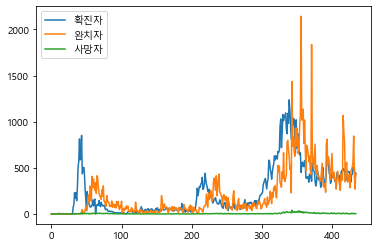

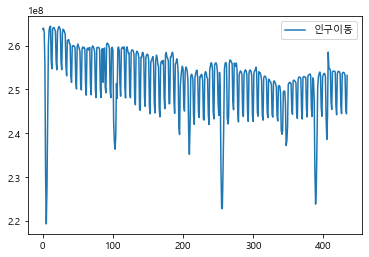

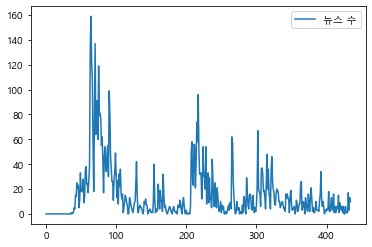

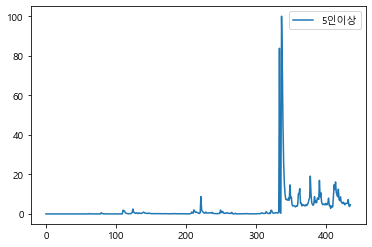

In [6]:
covid19.plot()
local_people_df.plot()
news.plot()
search_covid19.plot()

# 단일 데이터 모델

In [86]:
df_sn = pd.merge(search_covid19, news, on='날짜')
df_snp = pd.merge(df_sn, local_people_df, on='날짜')
df_snpc = pd.merge(df_snp, covid19, on='날짜')

# df_snpc.set_index('날짜', inplace=True)
df_snpc.drop(['날짜'], axis='columns', inplace=True)

df_snpc = df_snpc[{'확진자', '뉴스 수', '완치자', '인구이동', '5인이상'}]
df_snpc

,5인이상,완치자,확진자,뉴스 수,인구이동
0,0.00000,0,1,0,263707987
1,0.00000,0,0,0,263999557
2,0.00000,0,0,0,263092698
3,0.00000,0,0,0,255740975
4,0.00000,0,1,0,230503552
...,...,...,...,...,...
430,5.46614,562,494,1,253723156
431,7.22695,845,505,17,253132397
432,4.22074,420,482,3,245764635
433,3.72146,269,384,13,244437877


In [53]:
dfv_snpc = df_snpc.values 
df_snpc.shape, dfv_snpc

timestep = 3
lag = 1

covid_x, covid_y = split_mult_data(dfv_snpc, timestep, lag)

# for i in range(424,len(covid_x)):
#     print('covid_x : ',covid_x[i], 'covid_y : ', covid_y[i])
    
covid_features = covid_x.shape[2]
covid_x.shape, covid_y.shape

covid_train_x, covid_val_x, covid_test_x, covid_train_y, covid_val_y, covid_test_y = split(covid_x, covid_y)
len(covid_train_x), len(covid_val_x), len(covid_test_x), len(covid_train_y), len(covid_val_x), len(covid_test_y)

######## time_step 2이상 일 때 #########
n_covid_train_x = covid_train_x.reshape(covid_train_x.shape[0], covid_train_x.shape[1]*covid_train_x.shape[2])

n_covid_val_x = covid_val_x.reshape(covid_val_x.shape[0], covid_train_x.shape[1]*covid_val_x.shape[2])
n_covid_test_x = covid_test_x.reshape(covid_test_x.shape[0], covid_train_x.shape[1]*covid_test_x.shape[2])

n_covid_train_x.shape

# 데이터 정규화
covid_train_x, covid_val_x, covid_test_x = normalization(n_covid_train_x, n_covid_val_x, n_covid_test_x)

# 형태 복원 - 코로나 데이터
# covid_train_x = covid_train_x.reshape(covid_train_x.shape[0], covid_x.shape[1], covid_x.shape[2])
# covid_val_x = covid_val_x.reshape(covid_val_x.shape[0], covid_x.shape[1], covid_x.shape[2])
# covid_test_x = covid_test_x.reshape(covid_test_x.shape[0], covid_x.shape[1], covid_x.shape[2])

covid_train_x.shape, covid_train_y.shape

((259, 12), (259, 1))

In [25]:
tf.random.set_seed(555)

# define model
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# fit model
hist = model.fit(covid_train_x, covid_train_y, epochs=1000, batch_size=5, callbacks=early_stopping, validation_data=(covid_val_x, covid_val_y))

Epoch 1/1000
52/52 [==============================] - 0s 4ms/step - loss: 25474.8184 - mae: 93.4233 - val_loss: 328907.0312 - val_mae: 438.6811
Epoch 2/1000
52/52 [==============================] - 0s 2ms/step - loss: 25354.9434 - mae: 92.9139 - val_loss: 327547.1875 - val_mae: 437.5941
Epoch 3/1000
52/52 [==============================] - 0s 2ms/step - loss: 25191.9277 - mae: 92.1657 - val_loss: 325695.4062 - val_mae: 436.1133
Epoch 4/1000
52/52 [==============================] - 0s 2ms/step - loss: 24963.2305 - mae: 91.3114 - val_loss: 323280.4375 - val_mae: 434.1856
Epoch 5/1000
52/52 [==============================] - 0s 2ms/step - loss: 24657.8633 - mae: 90.0717 - val_loss: 320068.9062 - val_mae: 431.5849
Epoch 6/1000
52/52 [==============================] - 0s 2ms/step - loss: 24273.6797 - mae: 88.5790 - val_loss: 316053.3125 - val_mae: 428.3125
Epoch 7/1000
52/52 [==============================] - 0s 2ms/step - loss: 23830.4434 - mae: 86.7103 - val_loss: 311381.0000 - val_mae: 4

52/52 [==============================] - 0s 2ms/step - loss: 10760.7617 - mae: 67.1848 - val_loss: 108446.9531 - val_mae: 232.3796
Epoch 114/1000
52/52 [==============================] - 0s 2ms/step - loss: 10703.9375 - mae: 66.6694 - val_loss: 107754.2969 - val_mae: 231.7283
Epoch 115/1000
52/52 [==============================] - 0s 2ms/step - loss: 10638.3213 - mae: 66.4732 - val_loss: 107370.6406 - val_mae: 231.4118
Epoch 116/1000
52/52 [==============================] - 0s 2ms/step - loss: 10579.6182 - mae: 66.5302 - val_loss: 105829.1250 - val_mae: 230.0535
Epoch 117/1000
52/52 [==============================] - 0s 2ms/step - loss: 10513.9609 - mae: 66.3084 - val_loss: 105515.5625 - val_mae: 229.9767
Epoch 118/1000
52/52 [==============================] - 0s 2ms/step - loss: 10465.1865 - mae: 65.6805 - val_loss: 105083.7500 - val_mae: 229.7509
Epoch 119/1000
52/52 [==============================] - 0s 2ms/step - loss: 10395.7236 - mae: 65.9982 - val_loss: 103602.8125 - val_mae: 22

Epoch 170/1000
52/52 [==============================] - 0s 2ms/step - loss: 7338.0659 - mae: 55.2776 - val_loss: 76974.3281 - val_mae: 195.6338
Epoch 171/1000
52/52 [==============================] - 0s 2ms/step - loss: 7273.7109 - mae: 54.7831 - val_loss: 76529.6875 - val_mae: 194.5577
Epoch 172/1000
52/52 [==============================] - 0s 2ms/step - loss: 7223.7559 - mae: 54.8738 - val_loss: 76241.3359 - val_mae: 193.8391
Epoch 173/1000
52/52 [==============================] - 0s 2ms/step - loss: 7166.3364 - mae: 54.3309 - val_loss: 75897.1406 - val_mae: 193.1002
Epoch 174/1000
52/52 [==============================] - 0s 2ms/step - loss: 7118.2539 - mae: 53.8614 - val_loss: 76017.9219 - val_mae: 193.2368
Epoch 175/1000
52/52 [==============================] - 0s 2ms/step - loss: 7058.9102 - mae: 54.0207 - val_loss: 75280.9375 - val_mae: 191.3931
Epoch 176/1000
52/52 [==============================] - 0s 2ms/step - loss: 7004.7217 - mae: 53.4829 - val_loss: 75248.6641 - val_mae: 1

Epoch 283/1000
52/52 [==============================] - 0s 2ms/step - loss: 3409.4255 - mae: 35.7571 - val_loss: 47121.5859 - val_mae: 117.8757
Epoch 284/1000
52/52 [==============================] - 0s 2ms/step - loss: 3395.0452 - mae: 35.7097 - val_loss: 47057.5117 - val_mae: 117.3839
Epoch 285/1000
52/52 [==============================] - 0s 2ms/step - loss: 3379.9749 - mae: 35.4559 - val_loss: 46493.5820 - val_mae: 116.7273
Epoch 286/1000
52/52 [==============================] - 0s 2ms/step - loss: 3366.9932 - mae: 35.4725 - val_loss: 46387.8516 - val_mae: 116.5125
Epoch 287/1000
52/52 [==============================] - 0s 2ms/step - loss: 3352.5510 - mae: 35.1701 - val_loss: 45914.2500 - val_mae: 115.9394
Epoch 288/1000
52/52 [==============================] - 0s 2ms/step - loss: 3339.3730 - mae: 35.1615 - val_loss: 45638.2656 - val_mae: 115.4648
Epoch 289/1000
52/52 [==============================] - 0s 2ms/step - loss: 3330.9448 - mae: 35.0121 - val_loss: 45295.1094 - val_mae: 1

52/52 [==============================] - 0s 2ms/step - loss: 2923.4033 - mae: 31.6309 - val_loss: 29559.7207 - val_mae: 93.1639
Epoch 341/1000
52/52 [==============================] - 0s 2ms/step - loss: 2912.4248 - mae: 31.5741 - val_loss: 29279.4219 - val_mae: 92.9682
Epoch 342/1000
52/52 [==============================] - 0s 2ms/step - loss: 2909.4165 - mae: 31.3485 - val_loss: 28985.9258 - val_mae: 92.8600
Epoch 343/1000
52/52 [==============================] - 0s 2ms/step - loss: 2904.9724 - mae: 31.3472 - val_loss: 28696.5352 - val_mae: 92.3296
Epoch 344/1000
52/52 [==============================] - 0s 2ms/step - loss: 2899.5879 - mae: 31.3738 - val_loss: 28388.8242 - val_mae: 91.9554
Epoch 345/1000
52/52 [==============================] - 0s 2ms/step - loss: 2899.7163 - mae: 31.3931 - val_loss: 28066.1641 - val_mae: 91.7777
Epoch 346/1000
52/52 [==============================] - 0s 2ms/step - loss: 2893.2893 - mae: 31.0535 - val_loss: 27803.4277 - val_mae: 91.3589
Epoch 347/1000

52/52 [==============================] - 0s 2ms/step - loss: 2682.8274 - mae: 28.1227 - val_loss: 9253.4121 - val_mae: 64.8914
Epoch 455/1000
52/52 [==============================] - 0s 2ms/step - loss: 2674.2937 - mae: 28.2608 - val_loss: 9109.0879 - val_mae: 64.2941
Epoch 456/1000
52/52 [==============================] - 0s 2ms/step - loss: 2674.5471 - mae: 28.2665 - val_loss: 9093.2539 - val_mae: 64.2125
Epoch 457/1000
52/52 [==============================] - 0s 2ms/step - loss: 2675.3762 - mae: 28.2907 - val_loss: 9012.0371 - val_mae: 63.8916
Epoch 458/1000
52/52 [==============================] - 0s 2ms/step - loss: 2672.4258 - mae: 28.3270 - val_loss: 9000.3086 - val_mae: 63.8322
Epoch 459/1000
52/52 [==============================] - 0s 2ms/step - loss: 2673.2563 - mae: 28.2940 - val_loss: 8951.4668 - val_mae: 63.5917
Epoch 460/1000
52/52 [==============================] - 0s 2ms/step - loss: 2670.4429 - mae: 28.3383 - val_loss: 8960.4502 - val_mae: 63.5407
Epoch 461/1000
52/52 

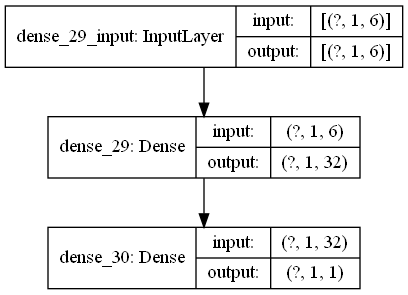

In [27]:
from keras.utils import plot_model
plot_model(model, to_file='model_20210124.png', show_shapes=True)

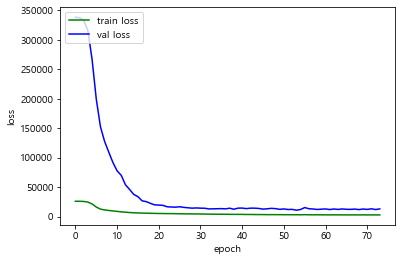

RMSE:  97.77
R-Square:  0.49


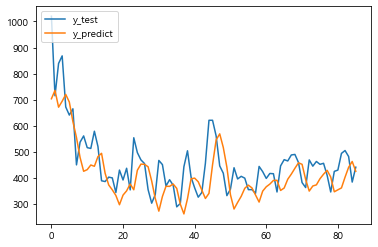

    y_test   y_predict
0     1020  703.431946
1      715  735.698730
2      839  671.223083
3      868  694.078918
4      672  720.132263
..     ...         ...
81     494  361.577545
82     505  402.697693
83     482  440.719116
84     384  462.897095
85     441  425.418274

[86 rows x 2 columns]


In [75]:
# 학습 시각화 함수
def learning_graph(hist):
    fig, loss_ax = plt.subplots()
    loss_ax.plot(hist.history['loss'],'g', label='train loss')
    loss_ax.plot(hist.history['val_loss'],'b', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    plt.show()
    
learning_graph(hist)

# 실제값, 예측값 그래프
y_predict = model.predict(covid_test_x) ####

# 에러율 - Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_predict, covid_test_y))
print('RMSE: ',rmse.round(2))

r = explained_variance_score(covid_test_y, y_predict)
print('R-Square: ',r.round(2))

fig, loss_ax = plt.subplots()
loss_ax.plot(covid_test_y, label='y_test')
loss_ax.plot(y_predict, label='y_predict')
loss_ax.legend(loc='upper left')
plt.show()

df = pd.DataFrame(covid_test_y)
df.insert(1,'y_predict',y_predict)
df.rename(columns={0:'y_test'}, inplace=True)
print(df)

In [45]:
# 반복문 사용
dfv_snpc = df_snpc.values

rmse =[]
r2 = []
lag = 1

for timestep in range(1, 8, 1): 
    covid_x, covid_y = split_mult_data(dfv_snpc, timestep, lag)
    covid_features = covid_x.shape[2]
    
    covid_train_x, covid_val_x, covid_test_x, covid_train_y, covid_val_y, covid_test_y = split(covid_x, covid_y)
    
    n_covid_train_x = covid_train_x.reshape(covid_train_x.shape[0], covid_train_x.shape[1]*covid_train_x.shape[2])

    n_covid_val_x = covid_val_x.reshape(covid_val_x.shape[0], covid_train_x.shape[1]*covid_val_x.shape[2])
    n_covid_test_x = covid_test_x.reshape(covid_test_x.shape[0], covid_train_x.shape[1]*covid_test_x.shape[2])
    
    # 데이터 정규화
    covid_train_x, covid_val_x, covid_test_x = normalization(n_covid_train_x, n_covid_val_x, n_covid_test_x)

    # 형태 복원 - 코로나 데이터
#     covid_train_x = covid_train_x.reshape(covid_train_x.shape[0], covid_x.shape[1], covid_x.shape[2])
#     covid_val_x = covid_val_x.reshape(covid_val_x.shape[0], covid_x.shape[1], covid_x.shape[2])
#     covid_test_x = covid_test_x.reshape(covid_test_x.shape[0], covid_x.shape[1], covid_x.shape[2])
    print(covid_train_x.shape, covid_train_y.shape)
    
    tf.random.set_seed(555)

    # define model
    model = Sequential()
    model.add(Dense(32, activation='relu',input_shape=(covid_train_x.shape[1],)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20)

    # fit model
    hist = model.fit(covid_train_x, covid_train_y, epochs=1000, batch_size=5, callbacks=early_stopping, validation_data=(covid_val_x, covid_val_y))

    y_predict = model.predict(covid_test_x) ####
    
    # 에러율 - Root Mean Squared Error
    Rmse = round(math.sqrt(mean_squared_error(y_predict, covid_test_y)), 2)
    R2 = round(explained_variance_score(covid_test_y, y_predict), 2)

    rmse.append(Rmse)
    r2.append(R2)

NameError: name 'df_snpc' is not defined

In [88]:
rmse

[90.46, 99.73, 97.93, 94.36, 101.9, 109.28, 94.0]

In [89]:
r2

[0.58, 0.57, 0.63, 0.6, 0.62, 0.66, 0.65]

Text(0, 0.5, 'RMSE')

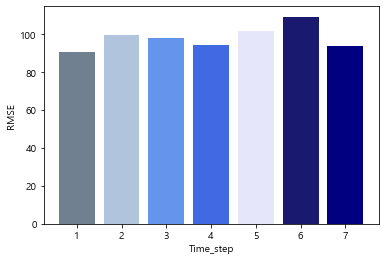

In [90]:
colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'lavender', 'midnightblue','navy']

num = []
for i in range(1, 8, 1):
    num.append(i)

plt.bar(num, rmse, color = colors)
plt.xlabel("Time_step")
plt.ylabel("RMSE")

Text(0, 0.5, 'R2')

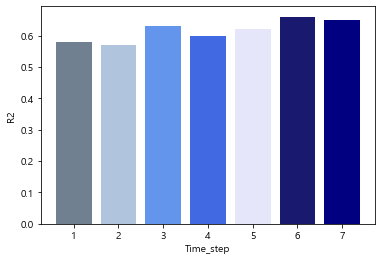

In [91]:
plt.bar(num,r2, color = colors)
plt.xlabel("Time_step")
plt.ylabel("R2")

# 실험

In [55]:
import numpy as np 
import pandas as pd
import seaborn as sns 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import LSTM

covid = pd.read_csv("covid19.csv")
covid = covid.drop('Unnamed: 0', axis=1)
covid = covid.drop('date', axis=1)
covid = covid[{'acc_decide', 'acc_recovered', 'acc_death',
       'recovered_per_day', 'death_per_day', 'decide_per_day'}]

covid1 = covid.values
rmse =[]
r2 = []

for timestep in range(1, 8, 1): 
    covid_x, covid_y = split_mult_data(covid1, timestep, 1)

    x_train, x_test, y_train, y_test = train_test_split(
        covid_x,
        covid_y,
        test_size=0.2,
        random_state=123,
        shuffle=False
    )
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
    
    # 데이터 정규화
    x_train, x_test = normalization(x_train, x_test)
    
    # define model
    model = Sequential()
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20)

    # fit model
    hist = model.fit(x_train, y_train, epochs=1000, batch_size=5, callbacks=early_stopping, 
                     validation_data=(x_test, y_test))

    y_predict = model.predict(x_test) ####
    
    # 에러율 - Root Mean Squared Error
    Rmse = round(math.sqrt(mean_squared_error(y_predict, y_test)), 2)
    R2 = round(explained_variance_score(y_test, y_predict), 2)

    rmse.append(Rmse)
    r2.append(R2)

Epoch 1/1000
70/70 [==============================] - 0s 2ms/step - loss: 101803.7578 - mae: 180.2369 - val_loss: 225499.0781 - val_mae: 458.5767
Epoch 2/1000
70/70 [==============================] - 0s 719us/step - loss: 101326.0156 - mae: 179.2360 - val_loss: 220002.7969 - val_mae: 452.4750
Epoch 3/1000
70/70 [==============================] - 0s 705us/step - loss: 98644.1953 - mae: 174.2947 - val_loss: 191823.8906 - val_mae: 419.8251
Epoch 4/1000
70/70 [==============================] - 0s 719us/step - loss: 89996.6953 - mae: 158.0358 - val_loss: 124211.8281 - val_mae: 328.2399
Epoch 5/1000
70/70 [==============================] - 0s 698us/step - loss: 73189.4141 - mae: 141.2075 - val_loss: 45220.2656 - val_mae: 163.9110
Epoch 6/1000
70/70 [==============================] - 0s 737us/step - loss: 57644.7031 - mae: 146.3627 - val_loss: 20498.6230 - val_mae: 96.0855
Epoch 7/1000
70/70 [==============================] - 0s 722us/step - loss: 49786.5547 - mae: 156.4592 - val_loss: 36054.

70/70 [==============================] - 0s 741us/step - loss: 31257.9199 - mae: 134.0375 - val_loss: 322960.6250 - val_mae: 551.0182
Epoch 1/1000
69/69 [==============================] - 0s 2ms/step - loss: 102199.9922 - mae: 180.9528 - val_loss: 222004.7656 - val_mae: 454.6966
Epoch 2/1000
69/69 [==============================] - 0s 742us/step - loss: 99575.1406 - mae: 176.2078 - val_loss: 184469.0312 - val_mae: 410.5934
Epoch 3/1000
69/69 [==============================] - 0s 723us/step - loss: 87801.9219 - mae: 155.5512 - val_loss: 77483.8203 - val_mae: 242.7316
Epoch 4/1000
69/69 [==============================] - 0s 731us/step - loss: 64005.6680 - mae: 136.7093 - val_loss: 29851.9277 - val_mae: 144.7070
Epoch 5/1000
69/69 [==============================] - 0s 766us/step - loss: 46287.7461 - mae: 147.9856 - val_loss: 107625.9062 - val_mae: 309.7505
Epoch 6/1000
69/69 [==============================] - 0s 730us/step - loss: 41889.7031 - mae: 155.6523 - val_loss: 167352.2500 - val_m

69/69 [==============================] - 0s 723us/step - loss: 32014.5078 - mae: 135.2421 - val_loss: 306277.1875 - val_mae: 537.0091
Epoch 22/1000
69/69 [==============================] - 0s 733us/step - loss: 31529.3672 - mae: 135.0909 - val_loss: 315631.0312 - val_mae: 546.0093
Epoch 23/1000
69/69 [==============================] - 0s 704us/step - loss: 30999.2070 - mae: 133.8290 - val_loss: 316662.1562 - val_mae: 547.4187
Epoch 24/1000
69/69 [==============================] - 0s 732us/step - loss: 30576.8926 - mae: 130.5214 - val_loss: 333263.0938 - val_mae: 562.3610
Epoch 1/1000
69/69 [==============================] - 0s 2ms/step - loss: 103704.9688 - mae: 183.3454 - val_loss: 219952.0156 - val_mae: 452.7331
Epoch 2/1000
69/69 [==============================] - 0s 723us/step - loss: 101909.0781 - mae: 180.0088 - val_loss: 192726.0625 - val_mae: 421.1537
Epoch 3/1000
69/69 [==============================] - 0s 760us/step - loss: 90917.4375 - mae: 162.0692 - val_loss: 86224.0859 - 

69/69 [==============================] - 0s 726us/step - loss: 31948.1895 - mae: 136.5083 - val_loss: 323819.8438 - val_mae: 554.2634
Epoch 19/1000
69/69 [==============================] - 0s 739us/step - loss: 31546.6797 - mae: 135.3303 - val_loss: 312575.0312 - val_mae: 544.7381
Epoch 20/1000
69/69 [==============================] - 0s 748us/step - loss: 30794.5547 - mae: 131.7120 - val_loss: 312230.0312 - val_mae: 544.8845
Epoch 21/1000
69/69 [==============================] - 0s 730us/step - loss: 30248.8516 - mae: 130.3513 - val_loss: 329273.4062 - val_mae: 560.4610
Epoch 22/1000
69/69 [==============================] - 0s 732us/step - loss: 29886.3262 - mae: 129.9420 - val_loss: 309131.0938 - val_mae: 542.5555
Epoch 23/1000
69/69 [==============================] - 0s 738us/step - loss: 29419.0605 - mae: 125.3141 - val_loss: 332219.8750 - val_mae: 563.3867
Epoch 1/1000
69/69 [==============================] - 0s 2ms/step - loss: 104390.1406 - mae: 184.5642 - val_loss: 220328.2500 

In [40]:
x_train[:1], y_train[:1]

(array([[[0, 0, 1, 0, 0]]], dtype=int64), array([[0]], dtype=int64))

In [39]:
covid = covid[{'acc_decide', 'acc_recovered', 'acc_death', 'recovered_per_day', 'death_per_day', 'decide_per_day'}]
covid

,decide_per_day,recovered_per_day,acc_recovered,acc_decide,acc_death,death_per_day
0,1,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,1,0,0,2,0,0
...,...,...,...,...,...,...
430,494,562,92630,100770,1716,7
431,505,845,93475,101275,1721,5
432,482,420,93855,101757,1722,1
433,384,269,94124,102141,1726,4


Text(0, 0.5, 'RMSE')

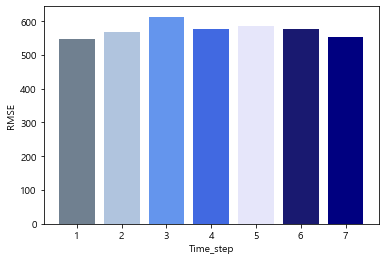

In [57]:
colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'lavender', 'midnightblue','navy']

num = []
for i in range(1, 8, 1):
    num.append(i)

plt.bar(num, rmse, color = colors)
plt.xlabel("Time_step")
plt.ylabel("RMSE")